# Using tk_r_em: Deep Neural Networks for Electron Microscopy Image Restoration

**Notebook Author:** Ivan Lobato

*Deep convolutional neural networks to restore single-shot electron microscopy images. Lobato, I., Friedrich, T., & Van Aert, S. (2024). npj Computational Materials 2024.*

**License:** [CC-BY 4.0 International License](https://creativecommons.org/licenses/by/4.0/?ref=ccchooser).

## Introduction

Welcome to this comprehensive tutorial on **tk_r_em**, a toolkit designed for applying deep neural networks to restore electron microscopy images. In this hands-on guide, you will learn how to leverage convolutional neural networks (CNNs) using TensorFlow to enhance the quality of electron microscopy (EM) images. Whether you are working with Transmission Electron Microscopy (TEM), Scanning Transmission Electron Microscopy (STEM), or Scanning Electron Microscopy (SEM) images, this notebook provides the tools and knowledge to improve your electron microscopy experimental images effectively.

### Objectives

By the end of this tutorial, you will:

- **Utilize Pretrained Models:** Apply pretrained models from the `tk_r_em` toolkit to restore and enhance electron microscopy images.
- **Manage Large Image Processing:** Implement patch-based prediction techniques to handle images that exceed GPU memory limitations, ensuring efficient processing without compromising image quality.
- **Process Time Series and Raw Data:** Handle and restore time series and data in their raw formats, including SER, TIF, and DM3.

### Toolkit Overview: `tk_r_em`

The `tk_r_em` toolkit includes a variety of neural network models tailored for different types of electron microscopy images. The available models are:

- **sfr_hrstem:** Single Frame High-Resolution Scanning Transmission Electron Microscopy (STEM)
- **sfr_lrstem:** Single Frame Low-Resolution Scanning Transmission Electron Microscopy (STEM)
- **sfr_hrtem:** Single Frame High-Resolution Transmission Electron Microscopy (TEM)
- **sfr_lrtem:** Single Frame Low-Resolution Transmission Electron Microscopy (TEM)
- **sfr_hrsem:** Single Frame High-Resolution Scanning Electron Microscopy (SEM)
- **sfr_lrsem:** Single Frame Low-Resolution Scanning Electron Microscopy (SEM)

Each model is optimized for specific imaging conditions and resolutions, allowing you to choose the best tool for your data restoration needs.

### Handling Large Images with Patch-Based Prediction

Electron microscopy images can be exceptionally large, often exceeding the memory capacity of standard GPUs. To address this, `tk_r_em` offers the `predict_patch_based` method. This approach preprocesses large images by dividing them into smaller overlapping patches. Each patch is processed individually, and the results are seamlessly stitched back together and weighted by a window function to avoid gridding artifacts, forming the complete restored image. This method ensures efficient use of GPU resources while maintaining high restoration quality.

### Tutorial Structure

The notebook is organized into the following sections:

1. **Environment Setup:** Instructions on installing necessary dependencies and setting up the TensorFlow environment.
2. **Pretrained Models for EM Image Restoration:** Guidance on utilizing pretrained models from `tk_r_em` to process and enhance electron microscopy images.
3. **Handling Large Images:** Step-by-step instructions on using the `predict_patch_based` method to manage and restore high-resolution images efficiently.

### Getting Started

Begin by setting up your Google Colab environment, installing the required packages, and cloning the `tk_r_em` repository. Follow the step-by-step instructions in the notebook to navigate through each section, execute the code cells, and observe the outcomes. By the end of this tutorial, you will be proficient in using deep neural networks to enhance and restore electron microscopy images, leveraging the powerful capabilities of the `tk_r_em` toolkit.

---

**Happy Learning!**

If you have any questions or need further assistance, feel free to reach out to me.


**Setup**

This step involves uninstalling the current TensorFlow version, installing the desired version, installing an additional toolkit (tk_r_em), and then restarting the runtime to apply the changes.

In [2]:
# Step 1: Uninstall the current TensorFlow version
!pip uninstall -y tensorflow

# Step 2: Install the desired TensorFlow version (e.g., 2.15)
!pip install tensorflow==2.15

# Step 3: Install the additional toolkit
!pip install tk_r_em

# Step 4: Restart the runtime to apply changes
import os
os.kill(os.getpid(), 9)

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0


**Verification**

After the runtime restarts, run this cell to verify the installation.

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.15.0
Num GPUs Available:  1


## 1: Inspecting the Network Architecture

To start, we will inspect the network architecture by using the `load_network` function from the `tk_r_em` toolkit and print its architecture.


In [3]:
# View network framework
from tk_r_em import load_network
# select one of the available networks from [sfr_hrsem, sfr_lrsem, sfr_hrstem, sfr_lrstem, sfr_hrtem, sfr_lrtem]
net_name = 'sfr_lrtem'
r_em_nn = load_network(net_name)
r_em_nn.summary()

Model: "gen_"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_gen (InputLayer)      [(None, None, None, 1)]      0         []                            
                                                                                                  
 gen_r_em_pp (Custom>lay_r_  ((None, None, None, 1),      0         ['input_gen[0][0]']           
 em_pp)                       (None, 1, 1, 1),                                                    
                              (None, 1, 1, 1))                                                    
                                                                                                  
 gen_fst_0_conv (Conv2D)     (None, None, None, 64)       640       ['gen_r_em_pp[0][0]']         
                                                                                               

## 2: Restoring Simulated Data for Different Microscope Modes

In this section, we will demonstrate how to restore simulated electron microscopy (EM) data using the `tk_r_em` toolkit for various microscope modes, including Transmission Electron Microscopy (TEM), Scanning Transmission Electron Microscopy (STEM), and Scanning Electron Microscopy (SEM). This will help you understand how the neural network models perform across different imaging modalities.

**Single Frame High-Resolution Scanning Transmission Electron Microscopy**

In [4]:
import matplotlib.pyplot as plt
from tk_r_em import load_network, load_sim_test_data


"""
Perform inference on test data using a pre-trained model and visualize the results.
"""
# select one of the available networks from [sfr_hrsem, sfr_lrsem, sfr_hrstem, sfr_lrstem, sfr_hrtem, sfr_lrtem]
net_name = 'sfr_hrstem'

# load its corresponding data
x, y = load_sim_test_data(net_name)

# load its corresponding model
r_em_nn = load_network(net_name)

n_data = x.shape[0]
batch_size = 8

# run inference
y_p = r_em_nn.predict(x, batch_size)

fig, axs = plt.subplots(3, n_data, figsize=(20, 6))

for ik in range(n_data):
    x_ik = x[ik, :, :, 0].squeeze()
    y_p_ik = y_p[ik, :, :, 0].squeeze()
    y_ik = y[ik, :, :, 0].squeeze()

    ir = 0
    axs[ir][ik].imshow(x_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Detected", fontsize=14, )

    ir = 1
    axs[ir][ik].imshow(y_p_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Restored", fontsize=14)
    axs[ir][ik].set_title(f'{ik}', fontsize=8)

    ir = 2
    axs[ir][ik].imshow(y_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Ground truth", fontsize=14)

plt.subplots_adjust(hspace=2, wspace=10)
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

**Single Frame Low-Resolution Scanning Transmission Electron Microscopy**

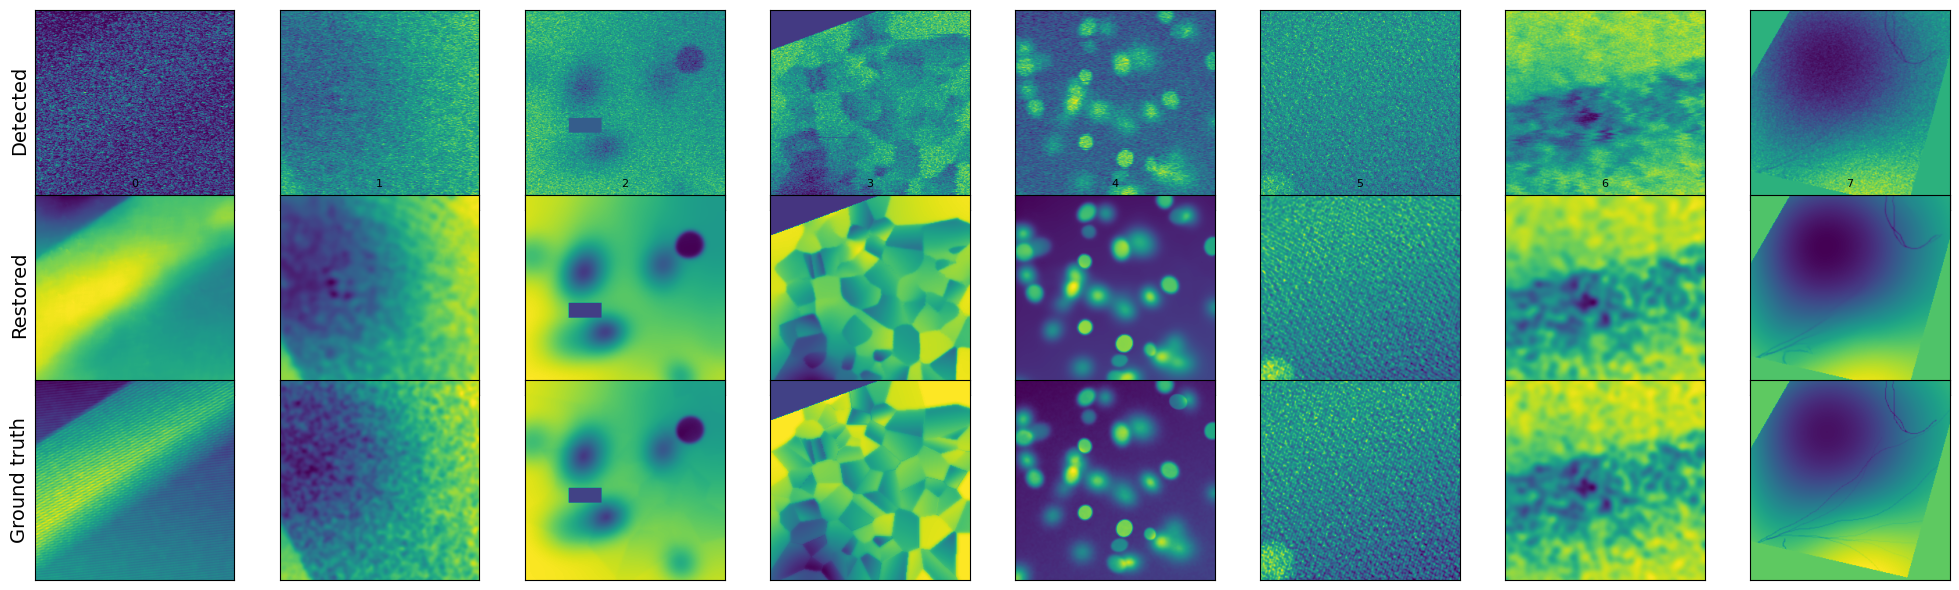

In [6]:
import matplotlib.pyplot as plt
from tk_r_em import load_network, load_sim_test_data


"""
Perform inference on test data using a pre-trained model and visualize the results.
"""
# select one of the available networks from [sfr_hrsem, sfr_lrsem, sfr_hrstem, sfr_lrstem, sfr_hrtem, sfr_lrtem]
net_name = 'sfr_lrstem'

# load its corresponding data
x, y = load_sim_test_data(net_name)

# load its corresponding model
r_em_nn = load_network(net_name)

n_data = x.shape[0]
batch_size = 8

# run inference
y_p = r_em_nn.predict(x, batch_size)

fig, axs = plt.subplots(3, n_data, figsize=(20, 6))

for ik in range(n_data):
    x_ik = x[ik, :, :, 0].squeeze()
    y_p_ik = y_p[ik, :, :, 0].squeeze()
    y_ik = y[ik, :, :, 0].squeeze()

    ir = 0
    axs[ir][ik].imshow(x_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Detected", fontsize=14, )

    ir = 1
    axs[ir][ik].imshow(y_p_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Restored", fontsize=14)
    axs[ir][ik].set_title(f'{ik}', fontsize=8)

    ir = 2
    axs[ir][ik].imshow(y_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Ground truth", fontsize=14)

plt.subplots_adjust(hspace=2, wspace=10)
plt.tight_layout()

**Single Frame Hig-Resolution Transmission Electron Microscopy**

In [7]:
import matplotlib.pyplot as plt
from tk_r_em import load_network, load_sim_test_data


"""
Perform inference on test data using a pre-trained model and visualize the results.
"""
# select one of the available networks from [sfr_hrsem, sfr_lrsem, sfr_hrstem, sfr_lrstem, sfr_hrtem, sfr_lrtem]
net_name = 'sfr_hrtem'

# load its corresponding data
x, y = load_sim_test_data(net_name)

# load its corresponding model
r_em_nn = load_network(net_name)

n_data = x.shape[0]
batch_size = 8

# run inference
y_p = r_em_nn.predict(x, batch_size)

fig, axs = plt.subplots(3, n_data, figsize=(20, 6))

for ik in range(n_data):
    x_ik = x[ik, :, :, 0].squeeze()
    y_p_ik = y_p[ik, :, :, 0].squeeze()
    y_ik = y[ik, :, :, 0].squeeze()

    ir = 0
    axs[ir][ik].imshow(x_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Detected", fontsize=14, )

    ir = 1
    axs[ir][ik].imshow(y_p_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Restored", fontsize=14)
    axs[ir][ik].set_title(f'{ik}', fontsize=8)

    ir = 2
    axs[ir][ik].imshow(y_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Ground truth", fontsize=14)

plt.subplots_adjust(hspace=2, wspace=10)
plt.tight_layout()

ValueError: axes don't match array

**Single Frame Low-Resolution Transmission Electron Microscopy**

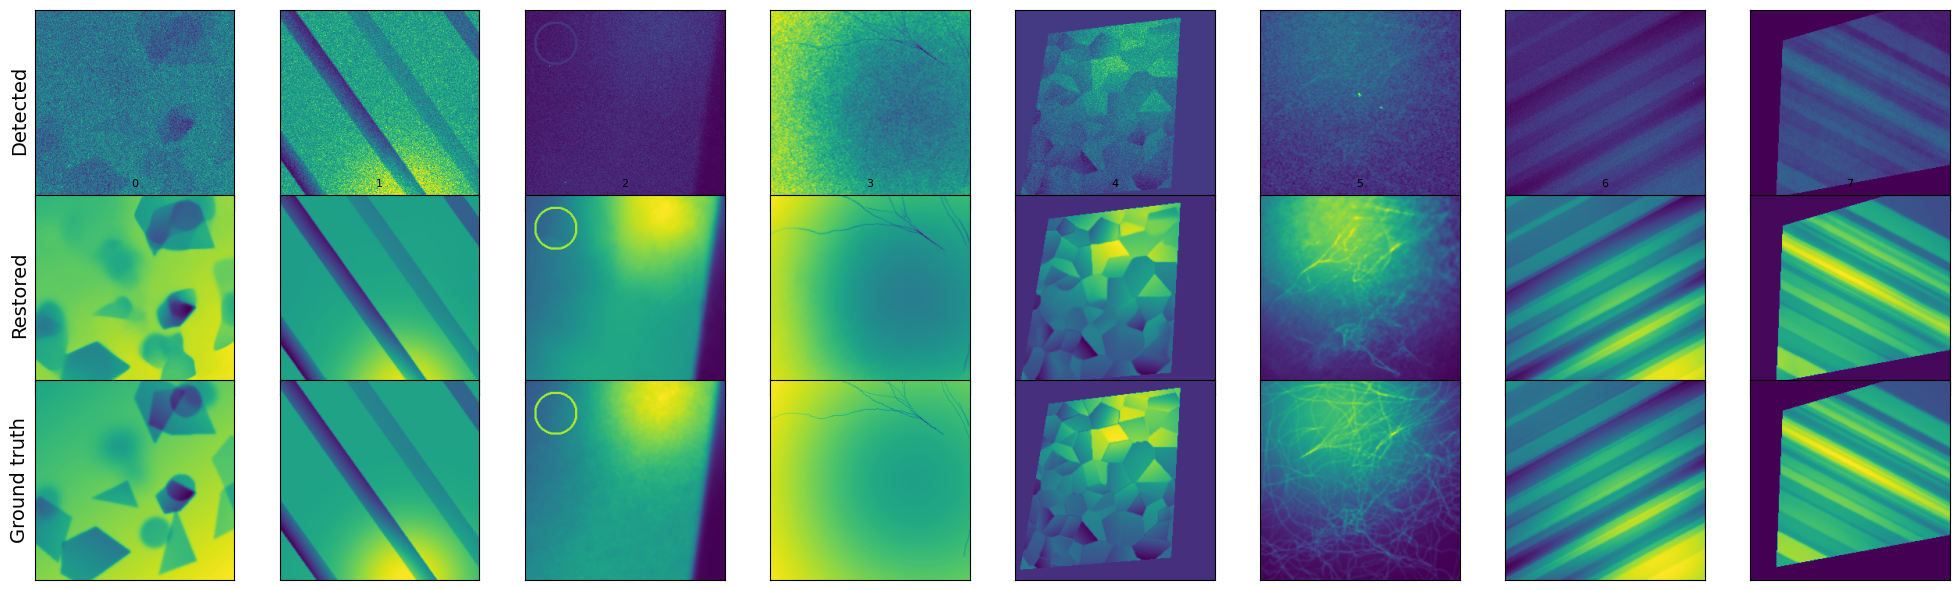

In [8]:
import matplotlib.pyplot as plt
from tk_r_em import load_network, load_sim_test_data


"""
Perform inference on test data using a pre-trained model and visualize the results.
"""
# select one of the available networks from [sfr_hrsem, sfr_lrsem, sfr_hrstem, sfr_lrstem, sfr_hrtem, sfr_lrtem]
net_name = 'sfr_lrtem'

# load its corresponding data
x, y = load_sim_test_data(net_name)

# load its corresponding model
r_em_nn = load_network(net_name)

n_data = x.shape[0]
batch_size = 8

# run inference
y_p = r_em_nn.predict(x, batch_size)

fig, axs = plt.subplots(3, n_data, figsize=(20, 6))

for ik in range(n_data):
    x_ik = x[ik, :, :, 0].squeeze()
    y_p_ik = y_p[ik, :, :, 0].squeeze()
    y_ik = y[ik, :, :, 0].squeeze()

    ir = 0
    axs[ir][ik].imshow(x_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Detected", fontsize=14, )

    ir = 1
    axs[ir][ik].imshow(y_p_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Restored", fontsize=14)
    axs[ir][ik].set_title(f'{ik}', fontsize=8)

    ir = 2
    axs[ir][ik].imshow(y_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Ground truth", fontsize=14)

plt.subplots_adjust(hspace=2, wspace=10)
plt.tight_layout()

**Single Frame High-Resolution Scanning Electron Microscopy**

In [9]:
import matplotlib.pyplot as plt
from tk_r_em import load_network, load_sim_test_data


"""
Perform inference on test data using a pre-trained model and visualize the results.
"""
# select one of the available networks from [sfr_hrsem, sfr_lrsem, sfr_hrstem, sfr_lrstem, sfr_hrtem, sfr_lrtem]
net_name = 'sfr_hrsem'

# load its corresponding data
x, y = load_sim_test_data(net_name)

# load its corresponding model
r_em_nn = load_network(net_name)

n_data = x.shape[0]
batch_size = 8

# run inference
y_p = r_em_nn.predict(x, batch_size)

fig, axs = plt.subplots(3, n_data, figsize=(20, 6))

for ik in range(n_data):
    x_ik = x[ik, :, :, 0].squeeze()
    y_p_ik = y_p[ik, :, :, 0].squeeze()
    y_ik = y[ik, :, :, 0].squeeze()

    ir = 0
    axs[ir][ik].imshow(x_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Detected", fontsize=14, )

    ir = 1
    axs[ir][ik].imshow(y_p_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Restored", fontsize=14)
    axs[ir][ik].set_title(f'{ik}', fontsize=8)

    ir = 2
    axs[ir][ik].imshow(y_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Ground truth", fontsize=14)

plt.subplots_adjust(hspace=2, wspace=10)
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

**Single Frame Low-Resolution Scanning Electron Microscopy**

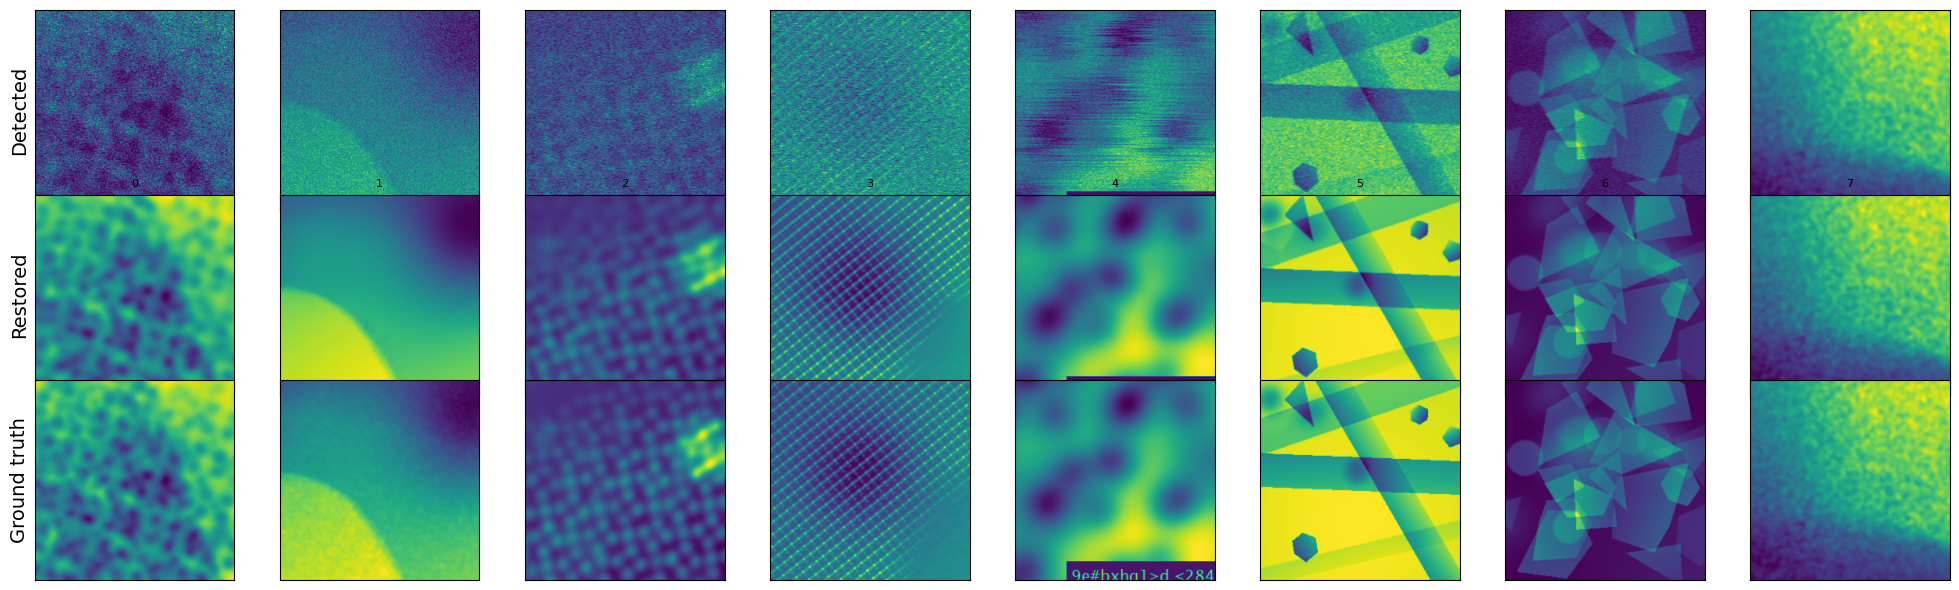

In [10]:
import matplotlib.pyplot as plt
from tk_r_em import load_network, load_sim_test_data


"""
Perform inference on test data using a pre-trained model and visualize the results.
"""
# select one of the available networks from [sfr_hrsem, sfr_lrsem, sfr_hrstem, sfr_lrstem, sfr_hrtem, sfr_lrtem]
net_name = 'sfr_lrsem'

# load its corresponding data
x, y = load_sim_test_data(net_name)

# load its corresponding model
r_em_nn = load_network(net_name)

n_data = x.shape[0]
batch_size = 8

# run inference
y_p = r_em_nn.predict(x, batch_size)

fig, axs = plt.subplots(3, n_data, figsize=(20, 6))

for ik in range(n_data):
    x_ik = x[ik, :, :, 0].squeeze()
    y_p_ik = y_p[ik, :, :, 0].squeeze()
    y_ik = y[ik, :, :, 0].squeeze()

    ir = 0
    axs[ir][ik].imshow(x_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Detected", fontsize=14, )

    ir = 1
    axs[ir][ik].imshow(y_p_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Restored", fontsize=14)
    axs[ir][ik].set_title(f'{ik}', fontsize=8)

    ir = 2
    axs[ir][ik].imshow(y_ik, cmap='viridis')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Ground truth", fontsize=14)

plt.subplots_adjust(hspace=2, wspace=10)
plt.tight_layout()

## 3: Restoring HR-STEM Experimental Datasets in Batch Mode

If the data fits within the GPU memory, we can utilize batch processing to restore multiple High-Resolution Scanning Transmission Electron Microscopy (HR-STEM) images simultaneously. This approach leverages the parallel processing capabilities of GPUs, enhancing efficiency and reducing overall processing time without compromising image quality. Batch mode processing is particularly beneficial when dealing with large datasets, allowing for streamlined workflows and more effective utilization of computational resources.


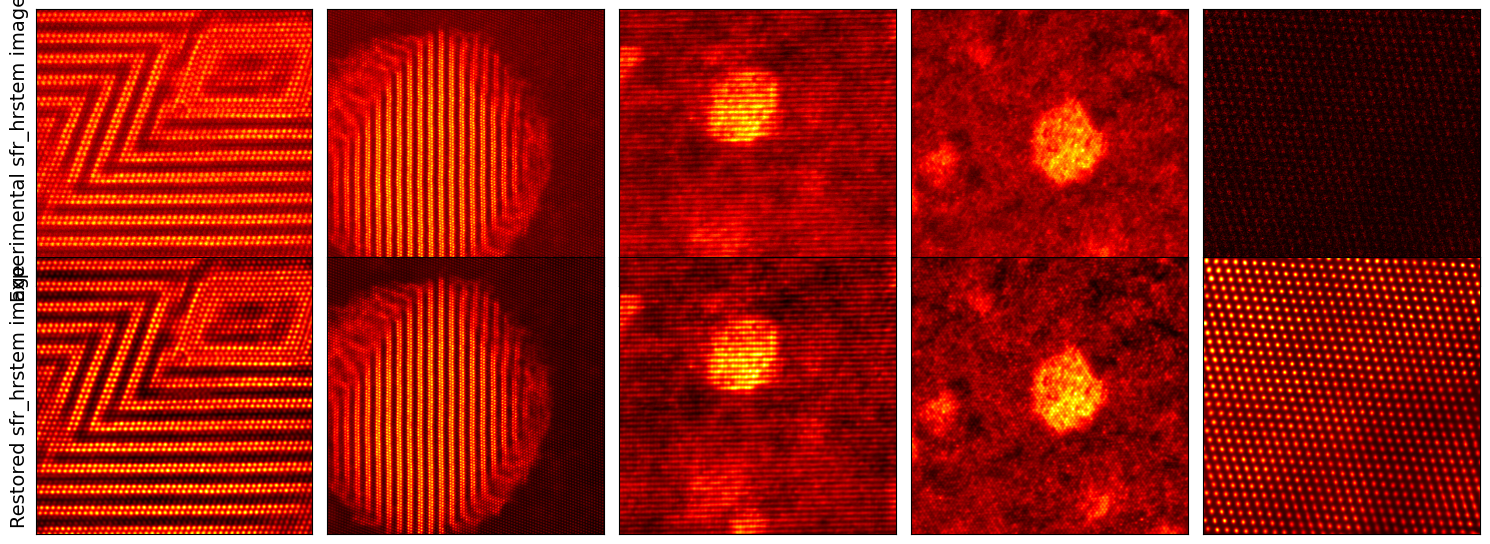

In [12]:
import matplotlib.pyplot as plt
from tk_r_em import load_network, load_sim_test_data


"""
Perform inference on test data using a pre-trained model and visualize the results.
"""
# select one of the available networks from [sfr_hrsem, sfr_lrsem, sfr_hrstem, sfr_lrstem, sfr_hrtem, sfr_lrtem]
net_name = 'sfr_hrstem'

# load experimental hrstem data
x = load_hrstem_exp_test_data('exp_hrstem')

# load its corresponding model
r_em_nn = load_network(net_name)

n_data = x.shape[0]
batch_size = 8

# run inference
y_p = r_em_nn.predict(x, batch_size)

fig, axs = plt.subplots(2, n_data, figsize=(15, 6))

for ik in range(n_data):
    x_ik = x[ik, :, :, 0].squeeze()
    y_p_ik = y_p[ik, :, :, 0].squeeze()

    ir = 0
    axs[ir][ik].imshow(x_ik, cmap='hot')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Experimental {net_name} image", fontsize=14, )

    ir = 1
    axs[ir][ik].imshow(y_p_ik, cmap='hot')
    axs[ir][ik].set_xticks([])
    axs[ir][ik].set_yticks([])
    axs[ir][ik].grid(False)

    if ik == 0:
        axs[ir][ik].set_ylabel(f"Restored {net_name} image", fontsize=14)

plt.subplots_adjust(hspace=2, wspace=10)
plt.tight_layout()

## 4: Restoring HR-STEM Experimental Data That Does Not Fit in GPU Memory

Electron microscopy images can be exceptionally large, often exceeding the memory capacity of standard GPUs or encountering memory constraints on your GPU hardware. To address this, `tk_r_em` offers the `predict_patch_based` method. This approach preprocesses large images by dividing them into smaller, overlapping patches. Each patch is processed individually, and the results are seamlessly stitched back together and weighted by a window function to avoid gridding artifacts, forming the complete restored image. This method ensures efficient use of GPU resources while maintaining high restoration quality, enabling the handling of extensive datasets without compromising performance.


We will use our model to denoise real electron microscopy images. Below is our first discovery of a new "zebra" precipitation phase, ζ(AgAl), in Al-Ag alloys. This phase exhibits a unique long-range ordered structure, composed of alternating densely-packed planes of aluminum and silver. [Article Link](https://doi.org/10.1016/j.actamat.2017.04.061)

In [13]:
from tk_r_em import load_network, load_hrstem_exp_test_data

"""
Perform inference on test data using a pre-trained model and visualize the results.
"""
# select one of the available networks from [sfr_hrsem, sfr_lrsem, sfr_hrstem, sfr_lrstem, sfr_hrtem, sfr_lrtem]
net_name = 'sfr_hrstem'

# load experimental hrstem data
x = load_hrstem_exp_test_data('sgl_exp_hrstem')

# load its corresponding model
r_em_nn = load_network(net_name)
# r_em_nn.summary()

# run inference
y_p = r_em_nn.predict_patch_based(x, patch_size=256, stride=128, batch_size=16)

fig, axs = plt.subplots(1, 2, figsize=(24, 12))
ir = 0
axs[ir].imshow(x, cmap='hot')
axs[ir].set_xticks([])
axs[ir].set_yticks([])
axs[ir].grid(False)
axs[ir].set_title(f"Experimental {net_name} image", fontsize=14, )

ir = 1
axs[ir].imshow(y_p, cmap='hot')
axs[ir].set_xticks([])
axs[ir].set_yticks([])
axs[ir].grid(False)
axs[ir].set_title(f"Restored {net_name} image", fontsize=14)

plt.subplots_adjust(hspace=2, wspace=10)
plt.tight_layout()
plt.savefig(f"restored_Zebra.png", format='png',dpi=600)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 5: Restoring time series

Electron microscopy images can be exceptionally large, often exceeding the memory capacity of standard GPUs or encountering memory constraints on your GPU hardware. To address this, `tk_r_em` offers the `predict_patch_based` method. This approach preprocesses large images by dividing them into smaller, overlapping patches. Each patch is processed individually, and the results are seamlessly stitched back together and weighted by a window function to avoid gridding artifacts, forming the complete restored image. This method ensures efficient use of GPU resources while maintaining high restoration quality, enabling the handling of extensive datasets without compromising performance.


In [ ]:
import imageio
import numpy as np
from tk_r_em import load_network  # Ensure this module is correctly imported
from tqdm import tqdm  # For progress tracking
import os

def denoise_grayscale_video_imageio_concatenated(input_video_path, net_name='sfr_hrstem', batch_size=8, concatenate=True):
    """
    Denoise a grayscale video by processing each frame through a pre-trained neural network using imageio.
    Optionally concatenate each original frame with its denoised counterpart horizontally in the output video.

    Parameters:
    - input_video_path: Path to the input grayscale video file.
    - net_name: Name of the pre-trained network to use.
    - batch_size: Number of frames to process in a batch.
    - concatenate: If True, concatenate original and denoised frames side by side. If False, save only denoised frames.
    """

    # Load the pre-trained neural network
    print("Loading the pre-trained neural network...")
    r_em_nn = load_network(net_name)
    print("Network loaded successfully.")

    # Initialize video reader
    try:
        reader = imageio.get_reader(input_video_path, 'ffmpeg')
        # get extension of the input video
        ext = "."+input_video_path.split('.')[-1]
        output_video_path = input_video_path.replace(ext, f'_restored{"_concatenated" if concatenate else ""}{ext}')
    except Exception as e:
        print(f"Error: Cannot open video file {input_video_path}. Exception: {e}")
        return

    # Retrieve video metadata
    try:
        meta_data = reader.get_meta_data()
        fps = meta_data.get('fps', 30)  # Default to 30 if fps not found
        # Retrieve video size from the first frame
        first_frame = reader.get_data(0)
        if first_frame.ndim == 3:
            height, width, channels = first_frame.shape
        else:
            height, width = first_frame.shape
        frame_height, frame_width = height, width
    except Exception as e:
        print(f"Error retrieving video metadata: {e}")
        reader.close()
        return

    # Determine output frame size based on concatenation
    if concatenate:
        output_width = frame_width * 2  # Original + Denoised side by side
    else:
        output_width = frame_width

    output_height = frame_height  # Height remains the same

    # Initialize video writer with appropriate frame size
    try:
        writer = imageio.get_writer(output_video_path, fps=fps, format='FFMPEG', macro_block_size=None)
    except Exception as e:
        print(f"Error: Cannot create video writer for {output_video_path}. Exception: {e}")
        reader.close()
        return

    frames = []
    frame_count = 0
    total_frames = meta_data.get('nframes', None)
    if total_frames is None:
        # If total frames not available, set to a large number; tqdm can handle it
        total_frames = 0

    print("Starting video denoising and concatenation process...")
    # Initialize progress bar
    with tqdm(total=total_frames, desc="Processing Frames", unit="frame") as pbar:
        for frame in reader:
            # Ensure frame is in grayscale
            if frame.ndim == 3 and frame.shape[2] == 3:
                # Convert RGB to Grayscale using luminosity method
                frame_gray = np.dot(frame[...,:3], [0.2989, 0.5870, 0.1140])
            else:
                frame_gray = frame  # Already grayscale

            # Normalize the frame to [0,1]
            frame_norm = frame_gray.astype(np.float32) / 255.0

            # Expand dimensions to match network input (batch_size, height, width, channels)
            frame_norm = np.expand_dims(frame_norm, axis=-1)  # Shape: (H, W, 1)
            frames.append(frame_norm)
            frame_count += 1

            # Process in batches
            if len(frames) == batch_size:
                input_batch = np.array(frames)  # Shape: (batch_size, H, W, 1)
                try:
                    y_p = r_em_nn.predict(input_batch, batch_size=batch_size)
                except Exception as e:
                    print(f"Error during model prediction: {e}")
                    reader.close()
                    writer.close()
                    return

                # Postprocess and write frames
                for i in range(len(y_p)):
                    denoised_frame = y_p[i]
                    # Assuming the network output is in [0,1], scale to [0,255]
                    denoised_frame = np.clip(denoised_frame * 255.0, 0, 255).astype(np.uint8)
                    denoised_frame = denoised_frame.squeeze()  # Shape: (H, W)

                    if concatenate:
                        # Prepare original frame
                        original_frame = (frames[i].squeeze() * 255.0).astype(np.uint8)  # Scale back to [0,255]

                        # Ensure both frames have the same shape
                        if original_frame.shape != denoised_frame.shape:
                            print("Error: Original and denoised frames have different shapes.")
                            reader.close()
                            writer.close()
                            return

                        # Stack frames horizontally
                        concatenated_frame = np.hstack((original_frame, denoised_frame))  # Shape: (H, 2W)

                        # Convert grayscale to RGB by stacking channels
                        concatenated_frame_rgb = np.stack([concatenated_frame]*3, axis=-1)  # Shape: (H, 2W, 3)
                    else:
                        # Only denoised frame
                        denoised_frame_rgb = np.stack([denoised_frame]*3, axis=-1)  # Convert to RGB
                        concatenated_frame_rgb = denoised_frame_rgb  # Alias for consistency

                    # Write the frame to the output video
                    writer.append_data(concatenated_frame_rgb)

                frames = []  # Reset frames list
                pbar.update(batch_size)

        # Process any remaining frames that didn't make a full batch
        if len(frames) > 0:
            input_batch = np.array(frames)
            try:
                y_p = r_em_nn.predict(input_batch, batch_size=len(frames))
            except Exception as e:
                print(f"Error during model prediction for remaining frames: {e}")
                reader.close()
                writer.close()
                return

            for i in range(len(y_p)):
                denoised_frame = y_p[i]
                denoised_frame = np.clip(denoised_frame * 255.0, 0, 255).astype(np.uint8)
                denoised_frame = denoised_frame.squeeze()

                if concatenate:
                    original_frame = (frames[i].squeeze() * 255.0).astype(np.uint8)
                    if original_frame.shape != denoised_frame.shape:
                        print("Error: Original and denoised frames have different shapes.")
                        reader.close()
                        writer.close()
                        return
                    concatenated_frame = np.hstack((original_frame, denoised_frame))
                    concatenated_frame_rgb = np.stack([concatenated_frame]*3, axis=-1)
                else:
                    denoised_frame_rgb = np.stack([denoised_frame]*3, axis=-1)
                    concatenated_frame_rgb = denoised_frame_rgb

                writer.append_data(concatenated_frame_rgb)

            pbar.update(len(frames))

    # Close reader and writer
    reader.close()
    writer.close()

    print(f"Denoised {'and concatenated ' if concatenate else ''}video saved to {output_video_path}")

if __name__ == "__main__":
    import sys

    # Determine the root directory based on the script's location
    root = os.path.dirname(os.path.abspath(__file__))

    # Example 1
    input_video = os.path.join(root, '41467_2022_32330_MOESM7_ESM.mov') # Path to your input grayscale video
    input_video = os.path.join(root, '41467_2023_37222_MOESM5_ESM.mov') # Path to your input grayscale video

    # Define whether to concatenate or not
    concatenate = True  # Set to False to save only denoised frames

    # Process Example 1
    denoise_grayscale_video_imageio_concatenated(input_video, net_name='sfr_hrtem', concatenate=concatenate)

Let us play the video

In [ ]:

# Display the restored video
from IPython.display import Video, display

# Specify the path to your output video
output_video_path = '41467_2023_37222_MOESM5_ESM_restored_concatenated.mov'  # Update as needed

# Embed and play the video in a loop
display(Video(output_video_path, embed=True, autoplay=True, loop=True, width=640, height=480))

## Conclusion

Congratulations! You have reached the end of this hands-on tutorial on restoring electron microscopy images using the `tk_r_em` toolkit. Throughout this guide, you have:

- **Inspected the Network Architecture:** Learned how to load and examine the structure of pretrained models tailored for various electron microscopy modes.
- **Restored Simulated Data:** Applied models to enhance simulated TEM, STEM, and SEM images, understanding the restoration process across different microscopy modalities.
- **Processed Experimental Data in Batch Mode:** Utilized batch processing techniques to efficiently restore multiple HR-STEM images, leveraging GPU capabilities for improved performance.
- **Handled Large Datasets:** Using the patch-based prediction methods to manage and restore exceptionally large images that exceed GPU memory constraints, ensuring high-quality restoration without compromising computational resources.

### Next Steps

With the knowledge and skills you've acquired, you can now:

- **Apply Restoration Techniques to Your Data:** Use the `tk_r_em` toolkit to enhance your own electron microscopy datasets, improving image quality for more accurate analysis.